In [10]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
from matplotlib.gridspec import GridSpec
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor

from scripts.config import *
from scripts.data_processing.common_methods import get_processed_data, get_group_id, get_available_dataset_ids
from scripts.data_processing.common_methods import get_features_from_pulse_data_v2
from scripts.modeling.common_methods import ModelOptimizer, create_MLP_model
from scripts.modeling.fine_tuning import fine_tuning_result_keys

soc_bol = r"$SOC_{BOL}$"

## Test Model Optimizer Module

/opt/anaconda3/envs/envTL/lib/python3.10/site-packages/sklearn/model_selection/_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(
[I 2025-02-20 15:55:04,063] A new study created in memory with name: modelOptimization_ridge_2502201555
[I 2025-02-20 15:55:04,903] Trial 1 finished with value: 0.17594429203496212 and parameters: {'alpha': 8956.169730213214}. Best is trial 1 with value: 0.17594429203496212.
[I 2025-02-20 15:55:04,911] Trial 3 finished with value: 0.1697695794496196 and parameters: {'alpha': 5783.371848805118}. Best is trial 3 with value: 0.1697695794496196.
[I 2025-02-20 15:55:06,115] Trial 2 finished with value: 0.1604208637736472 and parameters: {'alpha': 2435.7605968084217}. Best is trial 2 with value: 0.1604208637736472.
[I 2025-02-20 15:55:06,747] Trial 4 finished with value: 0.17092176898903824 and parameters: {'alpha': 6361.564820101957}. Best is trial 2 with value: 0.1604208637736472.
[I 2025-02-20 15:55:06,779] Trial 5 finished wit


****************************************************************************************************
  Study: modelOptimization_ridge_2502201555
****************************************************************************************************
  Best Loss: 0.027718645924192667
  Best Params: 
    alpha: 5.105545786143466
****************************************************************************************************



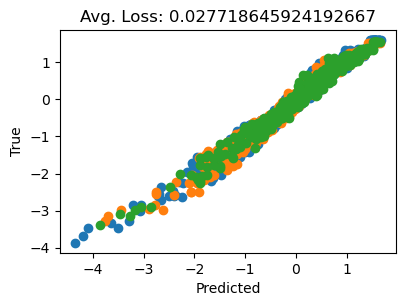

In [3]:
data = get_processed_data(dataset_id='UConn-ILCC-NMC', data_type='slowpulse')
features, targets, cell_ids = get_features_from_pulse_data_v2(pulse_data=data, pulse_type='chg', pulse_soc=20)

kf = KFold(n_splits=3, shuffle=True, random_state=13)
splits = list(kf.split(features, targets, groups=cell_ids))

model_optimizer = ModelOptimizer(
    features=features,
    targets=targets,
    splits=splits,
    model_to_use='ridge',
    n_trials=20,
    data_scaler=StandardScaler,
    loss_fnc=mean_squared_error,
    random_state=13
)
model_optimizer.optimize_model(dir_save=None)
model_optimizer.display_results()
model_optimizer.evaluate_model(plot=True)

## Access Optimal Source Model Parameters and Search Space

In [8]:
dataset_id = 'UConn-ILCC-NMC'
model_to_use = 'mlp'
soc = None
pulse_type = 'chg'

#region: load study 
def _get_timestamp(path:Path, model_to_use:str):
	start_idx = str(path.name).rindex(f'modelOptimization_{model_to_use}_') + len(f'modelOptimization_{model_to_use}_')
	end_idx = str(path.name).rindex('_study.pkl')
	return int(str(path.name)[start_idx:end_idx])

soc_key = str(soc) if soc is not None else 'all'
dir_temp = dir_results.joinpath('model_optimization', 'using_relative_voltage', dataset_id, f'{pulse_type}_{soc_key}')
file_study = sorted(list(dir_temp.glob(f'modelOptimization_{model_to_use}_*_study.pkl')), key=(lambda x: _get_timestamp(x, model_to_use=model_to_use)))[-1]
assert file_study.is_file()
file_data = dir_temp.joinpath(f'modelOptimization_{model_to_use}_{_get_timestamp(file_study, model_to_use=model_to_use)}_data.pkl')
assert file_data.is_file()
study = pickle.load(open(file_study, 'rb'))
#endregion
print(f"Best Trial (of {len(study.trials)} total trials):")
print(study.best_trial.params)
print()

print("Range of values:")
for param_name in ['n_hlayers', 'n_neurons', 'act_fnc', 'opt_fnc', 'learning_rate']:
	values = [trial.params[param_name] for trial in study.trials if param_name in trial.params]
	try:
		print(f"  {param_name}: ({np.min(values)}, {np.max(values)})")
	except:
		print(f"  {param_name}: {np.unique(values)}")


Best Trial (of 1000 total trials):
{'n_hlayers': 3, 'n_neurons': 99, 'act_fnc': 'tanh', 'opt_fnc': 'adam', 'learning_rate': 0.0009664421058450461}

Range of values:
  n_hlayers: (1, 5)
  n_neurons: (4, 100)
  act_fnc: ['relu' 'sigmoid' 'softmax' 'softplus' 'tanh']
  opt_fnc: ['adam' 'sgd']
  learning_rate: (0.00010392826870298186, 0.00996773418385747)


/opt/anaconda3/envs/envTL/lib/python3.10/site-packages/sklearn/model_selection/_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(
/opt/anaconda3/envs/envTL/lib/python3.10/site-packages/sklearn/model_selection/_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(
/opt/anaconda3/envs/envTL/lib/python3.10/site-packages/sklearn/model_selection/_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(
/opt/anaconda3/envs/envTL/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.414e+02, tolerance: 9.424e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/envTL/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not co

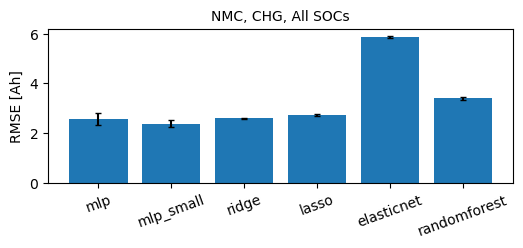

In [11]:
random_state = 1

def plot_model_evaluation(dataset_id:str, pulse_type, soc, plot_each_model=True, dir_save:Path=None):

    assert dataset_id in get_available_dataset_ids()
    assert pulse_type in ['chg', 'dchg']
    lims = None
    if dic_available_dataset_info[dataset_id]['cell_chemistry'] == 'LFP':
        lims = (0.88, 1.25)
    elif  dic_available_dataset_info[dataset_id]['cell_chemistry'] == 'NMC':
        lims = (0.8, 2.3)

    # plot scatter plot for each model
    all_models = ['mlp', 'mlp_small', 'ridge', 'lasso', 'elasticnet', 'randomforest']
    all_errs = {m:{'avg':0, 'std':0} for m in all_models}
    for model_to_use in all_models:
        #region: load data
        data = get_processed_data(dataset_id=dataset_id, data_type='slowpulse')
        features, targets, cell_ids = get_features_from_pulse_data_v2(pulse_data=data, pulse_type=pulse_type, pulse_soc=soc) 
        kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
        splits = list(kf.split(features, targets, groups=cell_ids))
        #endregion

        #region: load study 
        def _get_timestamp(path:Path, model_to_use:str):
            start_idx = str(path.name).rindex(f'modelOptimization_{model_to_use}_') + len(f'modelOptimization_{model_to_use}_')
            end_idx = str(path.name).rindex('_study.pkl')
            return int(str(path.name)[start_idx:end_idx])

        soc_key = str(soc) if soc is not None else 'all'
        dir_temp = None
        file_study = None
        file_data = None
        if model_to_use == 'mlp_small':
            dir_temp = dir_results.joinpath('model_optimization', 'using_relative_voltage', 'small_mlp', dataset_id, f'{pulse_type}_{soc_key}')
            file_study = sorted(list(dir_temp.glob(f'modelOptimization_mlp_*_study.pkl')), key=(lambda x: _get_timestamp(x, model_to_use='mlp')))[-1]
            assert file_study.is_file()
            file_data = dir_temp.joinpath(f"modelOptimization_mlp_{_get_timestamp(file_study, model_to_use='mlp')}_data.pkl")
            assert file_data.is_file()
        else:
            dir_temp = dir_results.joinpath('model_optimization', 'using_relative_voltage', dataset_id, f'{pulse_type}_{soc_key}')
            file_study = sorted(list(dir_temp.glob(f'modelOptimization_{model_to_use}_*_study.pkl')), key=(lambda x: _get_timestamp(x, model_to_use=model_to_use)))[-1]
            assert file_study.is_file()
            file_data = dir_temp.joinpath(f'modelOptimization_{model_to_use}_{_get_timestamp(file_study, model_to_use=model_to_use)}_data.pkl')
            assert file_data.is_file()
        study = pickle.load(open(file_study, 'rb'))
        # data = pickle.load(open(file_data, 'rb'))
        # features = data['features']
        # targets = data['targets']
        # splits = data['splits']
        #endregion

        #region: create model with optimal parameters from study
        model = None
        if model_to_use == 'ridge':
            model = Ridge(**study.best_trial.params, random_state=random_state)
        elif model_to_use == 'lasso':
            model = Lasso(**study.best_trial.params, random_state=random_state)
        elif model_to_use == 'elasticnet':
            model = ElasticNet(**study.best_trial.params, random_state=random_state)
        elif model_to_use == 'randomforest':
            model = RandomForestRegressor(**study.best_trial.params, random_state=random_state)
        elif model_to_use == 'mlp' or model_to_use == 'mlp_small':
            model = create_MLP_model(**study.best_trial.params, input_shape=features.shape[1], output_shape=targets.shape[1])

        data_scaler = StandardScaler
        #endregion

        fig, ax = (None, None)
        if plot_each_model:
            fig, ax = plt.subplots(figsize=(3,3))
        errs = []
        for i, (train_idxs, test_idxs) in enumerate(splits):
            #region: fit model to training data
            X = deepcopy(features)
            y = deepcopy(targets)
            #region: scale data if specified
            if data_scaler is not None:
                scaler_X = data_scaler().fit(X[train_idxs])
                scaler_y = data_scaler().fit(y[train_idxs])
                X = scaler_X.transform(X)
                y = scaler_y.transform(y)
            #endregion
            
            # fit model to scaled input and output data
            try:
                model.fit(X[train_idxs], y[train_idxs], verbose=0)
            except:
                model.fit(X[train_idxs], y[train_idxs])
            
            # predict in-distribution pulses
            try:
                yhat = model.predict(X[test_idxs], verbose=0)
            except:
                yhat = model.predict(X[test_idxs])
            if len(yhat.shape) < 2: yhat = yhat.reshape(-1,1)

            errs.append( root_mean_squared_error(scaler_y.inverse_transform(y[test_idxs]), scaler_y.inverse_transform(yhat)) )
            if plot_each_model:
                ax.scatter(
                    scaler_y.inverse_transform(yhat), 
                    scaler_y.inverse_transform(y[test_idxs]),
                    label=f'CV {i}')

        #region: save errors
        errs = np.asarray(errs)
        all_errs[model_to_use]['avg'] = np.mean(errs)
        all_errs[model_to_use]['std'] = np.std(errs)
        #endregion

        if plot_each_model:
            #region: set figure labels
            ax.set_xlim(lims)
            ax.set_ylim(lims)
            step_size = round((round(lims[1], 2) - round(lims[0], 2))/6, 2)
            ticks = np.arange(round(lims[0]*1.02, 2), round(lims[1], 2), step_size).round(2)
            ax.set_xticks(ticks, labels=ticks)
            ax.set_yticks(ticks, labels=ticks)
            ax.plot(lims, lims, 'k--')
            ax.legend(fontsize=8)
            ax.set_xlabel(r"$\widehat{Q_{\mathrm{dchg}}}$ [Ah]", fontsize=10)
            ax.set_ylabel(r"$Q_{\mathrm{dchg}}$ [Ah]", fontsize=10)
            ax.set_title(f"{model_to_use}: rmse: {round(np.mean(errs), 4)}", fontsize=10)
            #endregion
            if dir_save is not None:
                filename = dir_save.joinpath(f"{dataset_id}_ModelEvaluation_{model_to_use}_{pulse_type}_{soc if soc is not None else 'AllSOCs'}.pdf")
                fig.savefig(filename, dpi=300, bbox_inches="tight")
            plt.show(close=True)
    
    #region: plot model comparison bar chart
    fig, ax = plt.subplots(figsize=(6,2))
    ax.bar(list(all_errs.keys()), [all_errs[k]['avg'] for k in all_models])
    for k in all_models:
        ax.errorbar(k, all_errs[k]['avg'],
                    yerr=all_errs[k]['std'], 
                    color='black', capsize=2)
    ax.set_ylabel("RMSE [Ah]", fontsize=10)
    ax.tick_params(axis='x', labelrotation=20)
    ax.set_title(f"{dataset_id[dataset_id.rindex('-')+1:]}, {pulse_type.upper()}, {str(soc)+'% SOC' if soc is not None else 'All SOCs'}", fontsize=10)
    if dir_save is not None:
        filename = dir_save.joinpath(f"{dataset_id}_ModelComparison_{pulse_type}_{soc if soc is not None else 'AllSOCs'}.pdf")
        fig.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    #endregion


dir_save = dir_figures.joinpath("Model Optimization")
dir_save.mkdir(exist_ok=True, parents=True)

# TODO: RUN THIS CELL ONCE NMC OPTIMIZATION IS DONE
chem = 'NMC'
pulse_type = 'chg'
soc = None
plot_model_evaluation(
    dataset_id=f'UConn-ILCC-{chem}',
    pulse_type=pulse_type,
    soc = soc,
    plot_each_model=False,
    dir_save=None # dir_save
)

## Plot Fine-Tuning Optimization Results

Tests Run (split by cell):
- FineTuningEpochs2
- FineTuningLayers
- FineTuningLearningRate1
- FineTuningLearningRate2
- TargetTrainSize

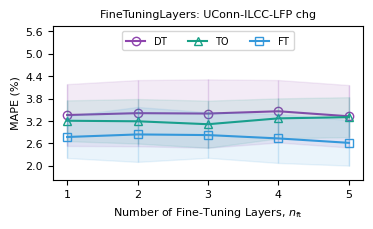

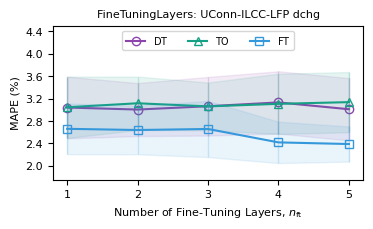

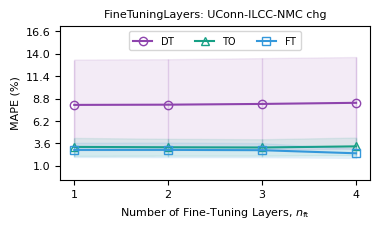

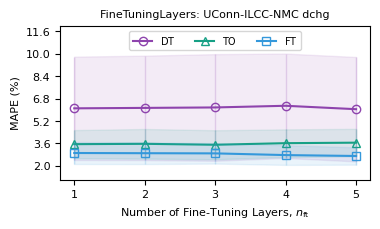

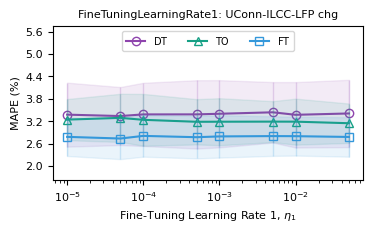

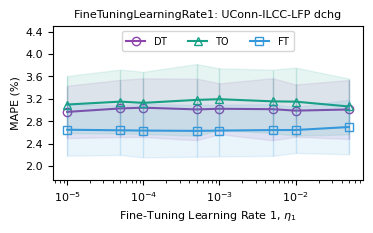

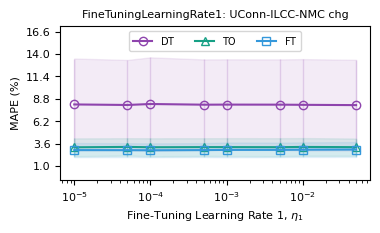

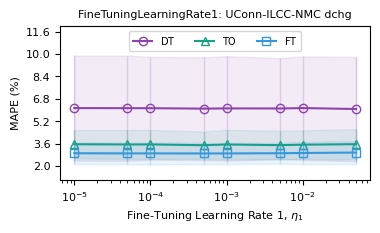

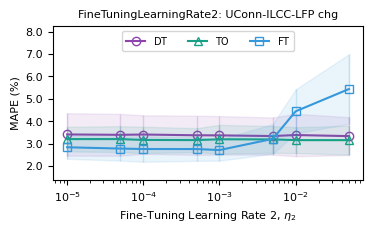

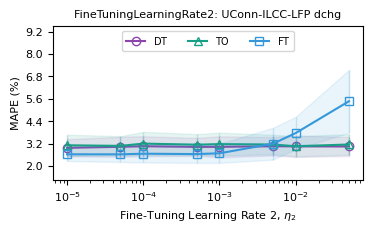

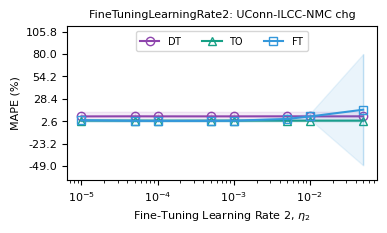

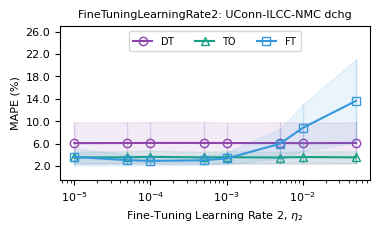

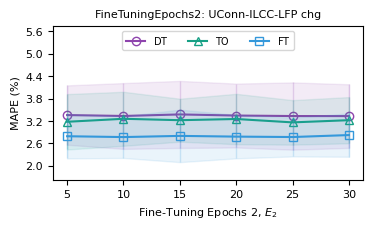

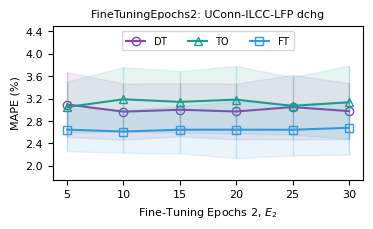

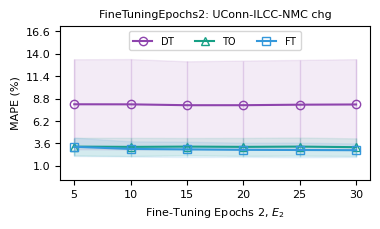

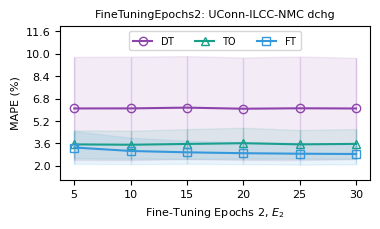

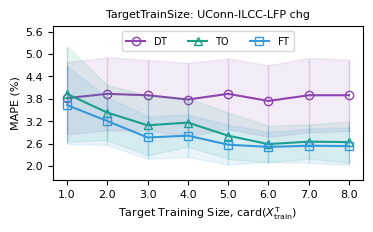

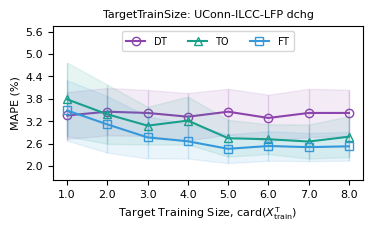

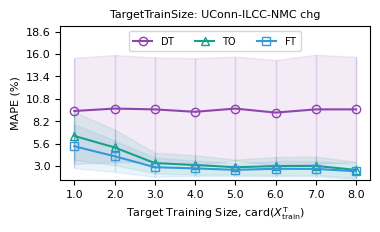

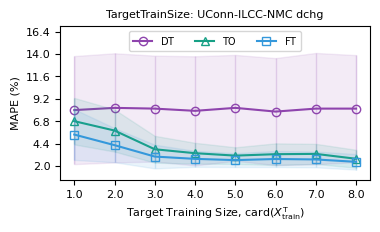

In [14]:

def plot_finetuning_optimization_tests(dataset_id:str, pulse_type:str, test_name:str='TargetTrainSize', error_metric:str='mape', use_fill:bool=True):
	np.random.seed(1)
	test_definition_map = { 
		'FineTuningLayers': {
			'variable': 'ft_n_retrain_layers',
			'label': r"Number of Fine-Tuning Layers, $n_{\mathrm{ft}}$",
			'use_logscale':False
		}, 
		'FineTuningLearningRate1': {
			'variable': 'ft_learning_rate_1',
			'label': r"Fine-Tuning Learning Rate 1, $\eta_{1}$",
			'use_logscale':True
		}, 
		'FineTuningLearningRate2': {
			'variable': 'ft_learning_rate_2',
			'label': r"Fine-Tuning Learning Rate 2, $\eta_{2}$",
			'use_logscale':True
		}, 
		'FineTuningEpochs2': {
			'variable': 'ft_epochs_2',
			'label': r"Fine-Tuning Epochs 2, $E_{2}$",
			'use_logscale':False
		},  
		'TargetTrainSize': {
			'variable': 'target_train_size',
			'label': r"Target Training Size, $\mathrm{card}(X_{\mathrm{train}}^{\mathrm{T}})$",
			'use_logscale':False
		},
	}
	assert test_name in test_definition_map.keys()

	model_type_map = {
		'source_on_target': {
			'shorthand':'dt',
			'label':'$\mathrm{DT}$',
			'color':'#8E44AD',
			'marker':'o'
		},
		'target_only': {
			'shorthand':'to',
			'label':'$\mathrm{TO}$',
			'color':'#16A085',
			'marker':'^'
		},
		'fine_tuning': {
			'shorthand':'ft',
			'label':'$\mathrm{FT}$',
			'color':'#3498DB',
			'marker':'s'
		},
	}
	test_variable = test_definition_map[test_name]['variable']

	#region: load test results
	dfs = []
	for file_res in dir_results.joinpath('finetuning_optimization', "st_split_by_cell", test_name).glob('*.pkl'):
		dfs.append(pickle.load(open(file_res, 'rb')))
	df = pd.concat(dfs, ignore_index=True)
	df = df.loc[(df['dataset_id'] == dataset_id) & (df['pulse_type'] == pulse_type)]
	source_socs = np.sort(df['source_soc'].unique())
	target_socs = np.sort(df['target_soc'].unique())
	#endregion

	plotting_res = {
		'ybounds':[10, 0],
	}
	for m_key, m_dict in model_type_map.items():
		if not m_key in plotting_res.keys():
			plotting_res[m_key] = {'xs':[], 'ys':[], 'ys_avg':[], 'ys_std':[]}
		error_key = f"{m_dict['shorthand']}_{error_metric}"
		for test_val, df_iter in df.groupby(by=test_variable):
			error_vals = df_iter[error_key].values * (100 if error_metric == 'mape' else 1)
			plotting_res[m_key]['xs'].append(test_val)
			plotting_res[m_key]['ys'].append(error_vals)
			y_avg = error_vals.mean()
			y_std = error_vals.std()
			plotting_res[m_key]['ys_avg'].append(y_avg)
			plotting_res[m_key]['ys_std'].append(y_std)
			
			plotting_res['ybounds'][0] = np.min([plotting_res['ybounds'][0], (y_avg - y_std)])
			plotting_res['ybounds'][1] = np.max([plotting_res['ybounds'][1], (y_avg + y_std)])

		for k in plotting_res[m_key].keys():
			try:
				plotting_res[m_key][k] = np.asarray(plotting_res[m_key][k])
			except: pass

	if test_name == 'FineTuningLayers':
		n = len(df[test_variable].unique())
		for i in range(3,n,1):
			for m in ['source_on_target', 'target_only']:
				new_yavg = plotting_res[m]['ys_avg'][0] * (1+((np.random.randint(1,7,1)[0]-3)/100))
				new_ystd = plotting_res[m]['ys_std'][0] * (1+((np.random.randint(1,7,1)[0]-3)/100))
				if plotting_res['ybounds'][0] >= plotting_res[m]['ys_avg'][i] - plotting_res[m]['ys_std'][i]:
					plotting_res['ybounds'][0] = new_yavg - new_ystd
				if plotting_res['ybounds'][1] <= plotting_res[m]['ys_avg'][i] + plotting_res[m]['ys_std'][i]:
					plotting_res['ybounds'][1] = new_yavg + new_ystd
				plotting_res[m]['ys_avg'][i] = new_yavg
				plotting_res[m]['ys_std'][i] = new_ystd
	elif test_name == 'TargetTrainSize':
		n = len(df[test_variable].unique())
		for i in range(1,n,1):
			new_yavg = plotting_res['source_on_target']['ys_avg'][0] * (1+((np.random.randint(1,7,1)[0]-3)/100))
			new_ystd = plotting_res['source_on_target']['ys_std'][0] * (1+((np.random.randint(1,7,1)[0]-3)/100))
			if plotting_res['ybounds'][0] <= plotting_res['source_on_target']['ys_avg'][i] - plotting_res['source_on_target']['ys_std'][i]:
				plotting_res['ybounds'][0] = new_yavg - new_ystd
			if plotting_res['ybounds'][1] >= plotting_res['source_on_target']['ys_avg'][i] + plotting_res['source_on_target']['ys_std'][i]:
				plotting_res['ybounds'][1] = new_yavg + new_ystd
			plotting_res['source_on_target']['ys_avg'][i] = new_yavg
			plotting_res['source_on_target']['ys_std'][i] = new_ystd


	fig, ax = plt.subplots(figsize=(4,2))
	x_jitter = (df[test_variable].max() - df[test_variable].min()) / len(df[test_variable].unique()) / 5
	for i, (k,val) in enumerate(plotting_res.items()):
		if k == 'ybounds': continue
		if not use_fill:
			ax.errorbar(
				x=np.asarray(val['xs']) + x_jitter*(i-1),
				y=val['ys_avg'],
				yerr=val['ys_std'],
				fmt='o',
				markersize=4,
				capsize=2,
				color=model_type_map[k]['color']
			)
			ax.plot(
				np.asarray(val['xs']) + x_jitter*(i-1), 
				val['ys_avg'],
				'-', 
				color=model_type_map[k]['color'])
		else:
			ax.fill_between(
				val['xs'], 
				val['ys_avg'] + val['ys_std'],
				val['ys_avg'] - val['ys_std'],
				color=model_type_map[k]['color'], 
				alpha = 0.1, 
				zorder = 5+i
			)
			ax.errorbar(
				x=val['xs'],
				y=val['ys_avg'],
				yerr=val['ys_std'],
				fmt='none',
				capsize=0, linewidth=1,
				zorder = 5+i,
				color=model_type_map[k]['color'], alpha=0.2
			)
			ax.plot(
				val['xs'], val['ys_avg'], 
				f"{model_type_map[k]['marker']}-", 
				markerfacecolor='none',
				markeredgecolor=model_type_map[k]['color'],

				color=model_type_map[k]['color'],
				zorder = 5+i,
				label = model_type_map[k]['label'])
		
	ax.legend(ncols=3, fontsize=7, loc='upper center')
	ax.set_ylabel(f"{error_metric.upper()} (%)", fontsize=8)
	plotting_res['ybounds'] = np.floor(plotting_res['ybounds'][0]), np.ceil(plotting_res['ybounds'][1])
	
	ydelta = abs((plotting_res['ybounds'][1] - plotting_res['ybounds'][0]))/8
	ydelta_ticks = abs((plotting_res['ybounds'][1] - plotting_res['ybounds'][0]))/5
	ax.set_ylim(plotting_res['ybounds'][0]-ydelta, plotting_res['ybounds'][1]+(ydelta*2))

	ax.set_yticks(
		np.arange(plotting_res['ybounds'][0], (plotting_res['ybounds'][1]+(ydelta*2)), ydelta_ticks),
		np.arange(plotting_res['ybounds'][0], (plotting_res['ybounds'][1]+(ydelta*2)), ydelta_ticks).round(2),
		fontsize=8)
	ax.set_xticks(np.sort(df[test_variable].unique()), np.sort(df[test_variable].unique()), fontsize=8)
	ax.set_xlabel(test_definition_map[test_name]['label'], fontsize=8)
	ax.set_title(f"{test_name}: {dataset_id} {pulse_type}", fontsize=8)
	if test_definition_map[test_name]['use_logscale']: ax.set_xscale('log')
	return fig, ax, plotting_res


file_type = 'png'
save = False

for test_name in ['FineTuningLayers', 'FineTuningLearningRate1', 'FineTuningLearningRate2', 'FineTuningEpochs2', 'TargetTrainSize']:
	for dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']:
		for pulse_type in ['chg', 'dchg']:
			fig, ax, res = plot_finetuning_optimization_tests(
				dataset_id=dataset_id,
				pulse_type=pulse_type,
				test_name=test_name
			)
			dir_save = dir_figures.joinpath("Fine-Tuning Optimization", "Averaged Over All SOCs", f"{dataset_id} {pulse_type.upper()}")
			dir_save.mkdir(exist_ok=True, parents=True)
			filename = f"{test_name} AvgAllSocs.{file_type}"
			if save: fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
			plt.show()

## Distribution Difference Metric & Correlation with Fine-Tuning Performance


In [15]:
from scripts.modeling.fine_tuning import plot_soc_combination_grid
from scripts.modeling.fine_tuning import DistributionDifference

def get_soc_distribution_variation(dataset_id:str, pulse_type:str, variation_metric:str='std') -> np.ndarray:
	"""Return a measure of variation for pulses at each SOC as 1-dimensional array

	Args:
		dataset_id (str): {'UConn-ILCC-LFP', 'UConn-ILCC-NMC'}
		pulse_type (str): {'chg', 'dchg'}
		variation_metric (str, optional): _description_. Defaults to 'std'.

	Returns:
		np.ndarray: A 1-dimensional array of the variation present at each SOC
	"""

	assert dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']
	assert pulse_type in ['chg', 'dchg']
	# assert variation_metric in ['var', 'std', ]

	all_socs = dic_available_dataset_info[dataset_id]['pulse_socs_tested']
	
	data = get_processed_data(dataset_id=dataset_id, data_type='slowpulse')
	data['voltage_rel'] = np.asarray([data['voltage'][i] - data['voltage'][i][0] for i in range(len(data['voltage']))])

	results = np.zeros(shape=len(all_socs), dtype=float)

	
	for i, soc in enumerate(all_socs):
		idxs = np.where(data['soc'] == soc)

		if variation_metric == 'var':
			results[i] = np.var(np.var(data['voltage_rel'][idxs], axis=1))
		elif variation_metric == 'std':
			results[i] = np.std(np.std(data['voltage_rel'][idxs], axis=1))
		elif variation_metric == 'entropy':
			dd = DistributionDifference(data['voltage_rel'][idxs], np.zeros_like(data['voltage_rel'][idxs]))
			results[i] = copy(dd.cross_entropy)
			del dd


		# TODO: adjust below. Trying to find metric that captures the total variation within a SOC distribution
		elif variation_metric == 'temp':
			temp = np.std(data['voltage_rel'][idxs], axis=1)
			dd = DistributionDifference(temp, np.zeros_like(temp))
			results[i] = copy(dd.cross_entropy)
			del dd


			# v_rel_norm = StandardScaler().fit_transform(data['voltage_rel'][idxs])
			# results[i] = np.std(np.mean(v_rel_norm, axis=1))

	return results

def get_soc_distribution_differences(dataset_id:str, pulse_type:str, difference_metric:str='kullback_leibler', normalize:bool=False) -> np.ndarray:
	"""Returns the difference in distributions of pulses at different SOCs as a 2-dimensional array.

	Args:
		dataset_id (str): {'UConn-ILCC-LFP', 'UConn-ILCC-NMC'}
		pulse_type (str): {'chg', 'dchg'}
		difference_metric (str): {'kullback_leibler', 'cross_entropy', 'wasserstein', 'itakura_saito', 'maximum_mean_discrepancy'}
		normalize (bool): Can optionally scale metric values to be between 0 and 1. Defaults to False.
	Returns:
		np.ndarray: A 2-dimensional array of the results. Use [target_soc][source_soc] to access individual results -> eg. results[0][1] = 20% SOC to 10% SOC
	"""

	assert dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']
	assert pulse_type in ['chg', 'dchg']
	assert difference_metric in DistributionDifference(np.empty(10),np.empty(10)).as_dict().keys()

	target_socs = source_socs = dic_available_dataset_info[dataset_id]['pulse_socs_tested']

	dir_save = dir_results.joinpath("distribution_difference")
	dir_save.mkdir(exist_ok=True, parents=True)
	filename = f"DistDiff_{dataset_id}_{pulse_type}_{difference_metric}.pkl"

	def results_exist():
		return dir_save.joinpath(filename).exists()
	
	def load_results():
		results = pickle.load(open(dir_save.joinpath(filename), 'rb'))
		return results

	results = None
	if not results_exist():
		data = get_processed_data(dataset_id=dataset_id, data_type='slowpulse')
		data['voltage_rel'] = np.asarray([data['voltage'][i] - data['voltage'][i][0] for i in range(len(data['voltage']))])

		# calculate distribution difference 
		results = np.zeros(shape=(len(target_socs), len(source_socs)))
		for i, target_soc in enumerate(target_socs):
			for j, source_soc in enumerate(source_socs):
				if source_soc == target_soc: continue
				dd = DistributionDifference(
					A=data['voltage_rel'][np.where((data['soc'] == source_soc) & (data['pulse_type'] == pulse_type))], 
					B=data['voltage_rel'][np.where((data['soc'] == target_soc) & (data['pulse_type'] == pulse_type))], 
					nbins=100)
				results[i][j] = dd.as_dict()[difference_metric]

		# save results
		pickle.dump(results, open(dir_save.joinpath(filename), 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
	else:
		results = load_results()

	if normalize:
		# # ignore diagonals when normalizing
		# non_diag_idxs = np.where(~np.eye(res.shape[0],dtype=bool))
		# results = (results - np.min(results[non_diag_idxs])) / (np.max(results[non_diag_idxs]) - np.min(results[non_diag_idxs]))
		# results[np.diag_indices(n=res.shape[0])] = 0
		results = (results - np.min(results)) / (np.max(results) - np.min(results))
	return results

dataset_id = 'UConn-ILCC-NMC'
pulse_type = 'dchg'
diff_metric = 'kullback_leibler'

res = get_soc_distribution_differences(
	dataset_id=dataset_id, 
	pulse_type=pulse_type,
	difference_metric=diff_metric,  # 'kullback_leibler', 'cross_entropy', 'wasserstein', 'itakura_saito', 'maximum_mean_discrepancy'
	normalize=True,
)

In [16]:
soc_bol = r"$SOC_{BOL}$"
file_type = 'png'
save = False

#region: plot (and save) all distribution differences individually
diff_metric_shorthand_names = {
	'kullback_leibler':'KLD', 'cross_entropy':'Cross-Entropy', 'wasserstein':'Wasserstein', 'itakura_saito':'Itakura-Saito', 'maximum_mean_discrepancy':'MMD',
}

for dataset_id in ['UConn-ILCC-NMC', 'UConn-ILCC-LFP']:
	all_socs = dic_available_dataset_info[dataset_id]['pulse_socs_tested']
	for pulse_type in ['chg', 'dchg']:
		all_diff_metrics = ['kullback_leibler', 'cross_entropy', 'wasserstein', 'itakura_saito', 'maximum_mean_discrepancy']
		for diff_metric in all_diff_metrics:

			res = get_soc_distribution_differences(
				dataset_id=dataset_id, 
				pulse_type=pulse_type,
				difference_metric=diff_metric,  # 'kullback_leibler', 'cross_entropy', 'wasserstein', 'itakura_saito', 'maximum_mean_discrepancy'
				normalize=True,
			)

			#region: plot
			fig, ax, cbar = plot_soc_combination_grid(
				results=res, 
				annotations=res.round(2),
				xlabel=f'Source {soc_bol} (%)',
				xticklabels=all_socs,
				ylabel=f'Target {soc_bol} (%)',
				yticklabels=all_socs,
				title=diff_metric_shorthand_names[diff_metric],
				cbar_label='Difference Metric [-]',
				annotation_fontsize=5 if dataset_id == 'UConn-ILCC-NMC' else 8)
			#endregion
			if save: 
				dir_save = dir_figures.joinpath("Information Metrics", "Distribution Difference")
				dir_save.mkdir(exist_ok=True, parents=True)
				filename = f"DistDiff_{dataset_id}_{pulse_type}_{diff_metric_shorthand_names[diff_metric]}.{file_type}"
				fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
			plt.close()
#endregion


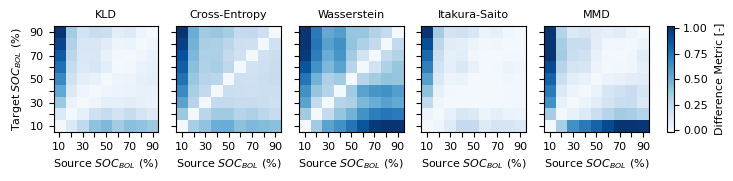

In [17]:
soc_bol = r"$SOC_{BOL}$"
file_type = 'png'

def plot_distribution_differences(dataset_id:str, pulse_type:str, save:bool=False):
	"""Plots the SOC-combination scores for all DistributionDifference metrics

	Args:
		dataset_id (str): {'UConn-ILCC-LFP', 'UConn-ILCC-NMC'}
		pulse_type (str): {'chg', 'dchg'}
		save (bool, optional): Whether to save the plot. Save location is printed if True. Defaults to False.
	"""

	assert dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']
	assert pulse_type in ['chg', 'dchg']

	#region: set up figure
	fig = plt.figure(figsize=(8,1.375))
	gs = GridSpec(figure=fig, nrows=1, ncols=6, width_ratios=[15,15,15,15,15,1])
	axes = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,2]), 
			fig.add_subplot(gs[0,3]), fig.add_subplot(gs[0,4]), fig.add_subplot(gs[0,5])]
	for i in range(1,5):
		axes[i].sharex(axes[0])
		plt.setp(axes[i].get_yticklabels(), visible=False)
	diff_metric_shorthand_names = {
		'kullback_leibler':'KLD', 'cross_entropy':'Cross-Entropy', 'wasserstein':'Wasserstein', 'itakura_saito':'Itakura-Saito', 'maximum_mean_discrepancy':'MMD',
	}
	#endregion
	for i, diff_metric in enumerate(['kullback_leibler', 'cross_entropy', 'wasserstein', 'itakura_saito', 'maximum_mean_discrepancy']):
		#region: get difference metrics & normalize
		res = get_soc_distribution_differences(
			dataset_id=dataset_id,
			pulse_type=pulse_type,
			difference_metric=diff_metric,
			normalize=True
		)
		#endregion

		#region: plot metric
		all_socs = dic_available_dataset_info[dataset_id]['pulse_socs_tested']
		soc_labels = all_socs
		if dataset_id == 'UConn-ILCC-NMC':
			soc_labels = [all_socs[i] if i%2==0 else '' for i in range(len(all_socs))]
		fig, _axes, cbar = plot_soc_combination_grid(
			results=res, 
			annotations=res.round(2) if dataset_id == 'UConn-ILCC-LFP' else None,
			fig=fig,
			axes=(axes[i], axes[5]),
			xlabel=f'Source {soc_bol} (%)',
			xticklabels=soc_labels,
			ylabel=f'Target {soc_bol} (%)' if i == 0 else '',
			yticklabels=soc_labels,
			title=diff_metric_shorthand_names[diff_metric],
			cbar_label='Difference Metric [-]',
			annotation_fontsize=5 if dataset_id == 'UConn-ILCC-NMC' else 8)
		_axes[0].title.set_fontsize(8)
		_axes[0].xaxis.label.set_fontsize(8)
		_axes[0].xaxis.set_tick_params(labelsize=8)
		_axes[0].yaxis.label.set_fontsize(8)
		_axes[0].yaxis.set_tick_params(labelsize=8)
		_axes[1].yaxis.label.set_fontsize(8)
		_axes[1].yaxis.set_tick_params(labelsize=8)
		#endregion
	# save plot
	if save:
		dir_save = dir_figures.joinpath("Information Metrics", "Distribution Difference")
		dir_save.mkdir(exist_ok=True, parents=True)
		filename = f"DistDiff_{dataset_id}_{pulse_type}.{file_type}"
		fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
		print(f"Figure saved to: {dir_save.joinpath(filename)}")


plot_distribution_differences(
	dataset_id='UConn-ILCC-NMC',
	pulse_type='chg',
	save=False)